In [ ]:
import torch
import os, cv2, random, glob
import numpy as np
import pandas as pd
from PIL import Image
from torchvision import transforms, models, datasets
from torchvision.ops import nms
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from matplotlib import pyplot as plt
import warnings
import configparser
warnings.filterwarnings('ignore')
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda True


In [2]:
# Load configuration
config = configparser.ConfigParser()
config.read('config.ini')
# Load parameters from config file
root = config.get('DEFAULT', 'root_dir')
IMAGE_ROOT = os.path.join(root, 'images/images')
DF_RAW = df = pd.read_csv(os.path.join(root, 'df.csv'))

In [3]:
label2target = {l:t+1 for t,l in enumerate(DF_RAW['LabelName'].unique())}
label2target['background'] = 0
target2label = {t:l for l,t in label2target.items()}
background_class = label2target['background']
num_classes = len(label2target)

In [4]:
def preprocess_image(img):
    img = torch.tensor(img).permute(2,0,1)
    return img.to(device).float()

In [5]:
class OpenDataset(Dataset):
    w, h = 224, 224
    def __init__(self, df, image_dir=IMAGE_ROOT):
        self.image_dir = image_dir
        self.files = glob.glob(self.image_dir+'/*')
        self.df = df
        self.image_infos = df.ImageID.unique()
    def __getitem__(self, ix):
        # load images and masks
        image_id = self.image_infos[ix]
        img_path = f'{self.image_dir}/{image_id}.jpg'
        #img_path = find(image_id, self.files)
        img = Image.open(img_path).convert("RGB")
        img = np.array(img.resize((self.w, self.h), resample=Image.BILINEAR))/255.
        data = df[df['ImageID'] == image_id]
        labels = data['LabelName'].values.tolist()
        data = data[['XMin','YMin','XMax','YMax']].values
        data[:,[0,2]] *= self.w
        data[:,[1,3]] *= self.h
        boxes = data.astype(np.uint32).tolist() # convert to absolute coordinates
        # torch FRCNN expects ground truths as a dictionary of tensors
        target = {}
        target["boxes"] = torch.Tensor(boxes).float()
        target["labels"] = torch.Tensor([label2target[i] for i in labels]).long()
        img = preprocess_image(img)
        return img, target
    def collate_fn(self, batch):
        return tuple(zip(*batch)) 

    def __len__(self):
        return len(self.image_infos)

In [6]:
from sklearn.model_selection import train_test_split
trn_ids, val_ids = train_test_split(df.ImageID.unique(), test_size=0.1, random_state=99)
trn_df, val_df = df[df['ImageID'].isin(trn_ids)], df[df['ImageID'].isin(val_ids)]
len(trn_df), len(val_df)

train_ds = OpenDataset(trn_df)
test_ds = OpenDataset(val_df)

train_loader = DataLoader(train_ds, batch_size=10, collate_fn=train_ds.collate_fn, drop_last=True)
test_loader = DataLoader(test_ds, batch_size=10, collate_fn=test_ds.collate_fn, drop_last=True)

In [7]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

def get_model():
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

In [8]:
# Defining training and validation functions for a single batch
def train_batch(inputs, model, optimizer):
    model.train()
    input, targets = inputs
    input = list(image.to(device) for image in input)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
    optimizer.zero_grad()
    losses = model(input, targets)
    loss = sum(loss for loss in losses.values())
    loss.backward()
    optimizer.step()
    return loss, losses

@torch.no_grad() # this will disable gradient computation in the function below
def validate_batch(inputs, model):
    model.train() # to obtain the losses, model needs to be in train mode only. # #Note that here we are not defining the model's forward method 
#and hence need to work per the way the model class is defined
    input, targets = inputs
    input = list(image.to(device) for image in input)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
    losses = model(input, targets)
    loss = sum(loss for loss in losses.values())
    return loss, losses

In [9]:
model = get_model().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.005,
                            momentum=0.9, weight_decay=0.0005)
n_epochs = 2

In [10]:
train_loss = []
test_loss = []
for epoch in range(n_epochs):
    _n = len(train_loader)
    for ix, inputs in enumerate(train_loader):
        loss, losses = train_batch(inputs, model, optimizer)
        loc_loss, regr_loss, loss_objectness, loss_rpn_box_reg = \
            [losses[k] for k in ['loss_classifier','loss_box_reg','loss_objectness','loss_rpn_box_reg']]
        pos = (epoch + (ix+1)/_n)
        # Log the losses
        print(f"Epoch {epoch+1}/{n_epochs}, Batch {ix+1}/{_n}, Loss: {loss.item()}, "
              f"Loc Loss: {loc_loss.item()}, Regr Loss: {regr_loss.item()}, "
              f"Objectness Loss: {loss_objectness.item()}, RPN Box Reg Loss: {loss_rpn_box_reg.item()}")
        
    _n = len(test_loader)
    for ix,inputs in enumerate(test_loader):
        loss, losses = validate_batch(inputs, model)
        loc_loss, regr_loss, loss_objectness, loss_rpn_box_reg = \
          [losses[k] for k in ['loss_classifier','loss_box_reg','loss_objectness','loss_rpn_box_reg']]
        pos = (epoch + (ix+1)/_n)
        # Log the losses
        print(f"Validation - Epoch {epoch+1}/{n_epochs}, Batch {ix+1}/{_n}, Loss: {loss.item()}, "
              f"Loc Loss: {loc_loss.item()}, Regr Loss: {regr_loss.item()}, "
              f"Objectness Loss: {loss_objectness.item()}, RPN Box Reg Loss: {loss_rpn_box_reg.item()}")
    # Save the model every 5 epochs
    if (epoch+1)%5==0:
        torch.save(model.state_dict(), f'model_epoch_{epoch+1}.pth')
    #if (epoch+1)%(n_epochs//5)==0: log.report_avgs(epoch+1)

Epoch 1/2, Batch 1/1370, Loss: 1.3694723844528198, Loc Loss: 1.1351909637451172, Regr Loss: 0.21059945225715637, Objectness Loss: 0.017110047861933708, RPN Box Reg Loss: 0.0065719932317733765
Epoch 1/2, Batch 2/1370, Loss: 0.755901038646698, Loc Loss: 0.47451314330101013, Regr Loss: 0.2627700865268707, Objectness Loss: 0.010409081354737282, RPN Box Reg Loss: 0.008208723738789558
Epoch 1/2, Batch 3/1370, Loss: 0.6243201494216919, Loc Loss: 0.29242613911628723, Regr Loss: 0.28866249322891235, Objectness Loss: 0.032427217811346054, RPN Box Reg Loss: 0.010804311372339725
Epoch 1/2, Batch 4/1370, Loss: 0.4857592284679413, Loc Loss: 0.24830257892608643, Regr Loss: 0.22178016602993011, Objectness Loss: 0.010100938379764557, RPN Box Reg Loss: 0.005575541406869888
Epoch 1/2, Batch 5/1370, Loss: 0.47387832403182983, Loc Loss: 0.2620859742164612, Regr Loss: 0.19393935799598694, Objectness Loss: 0.010400776751339436, RPN Box Reg Loss: 0.00745222857221961
Epoch 1/2, Batch 6/1370, Loss: 0.3651471436

In [11]:
#log.plot_epochs(['trn_loss','val_loss'])

In [12]:
from torchvision.ops import nms
def decode_output(output):
    'convert tensors to numpy arrays'
    bbs = output['boxes'].cpu().detach().numpy().astype(np.uint16)
    labels = np.array([target2label[i] for i in output['labels'].cpu().detach().numpy()])
    confs = output['scores'].cpu().detach().numpy()
    ixs = nms(torch.tensor(bbs.astype(np.float32)), torch.tensor(confs), 0.05)
    bbs, confs, labels = [tensor[ixs] for tensor in [bbs, confs, labels]]

    if len(ixs) == 1:
        bbs, confs, labels = [np.array([tensor]) for tensor in [bbs, confs, labels]]
    return bbs.tolist(), confs.tolist(), labels.tolist()

In [13]:
def show(image, bbs=None, texts=None, ax=None, title=None, sz=10, text_sz=1):
    if ax is None:
        fig, ax = plt.subplots(1,1, figsize=(sz,sz))
    text_sz = text_sz if text_sz else (max(sz) * 3 // 5)
    if title:
        ax.set_title(title)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    if bbs is not None:
        for ix, bb in enumerate(bbs):
            x,y,X,Y = bb
            cv2.rectangle(image, (x,y), (X,Y), (0,255,0), text_sz)
            cv2.putText(image, texts[ix], (x,y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), text_sz)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    #plt.imshow(img[:,:,::-1]) BGR->RGB剛好是倒過來，可以用-1
    ax.imshow(image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB dat

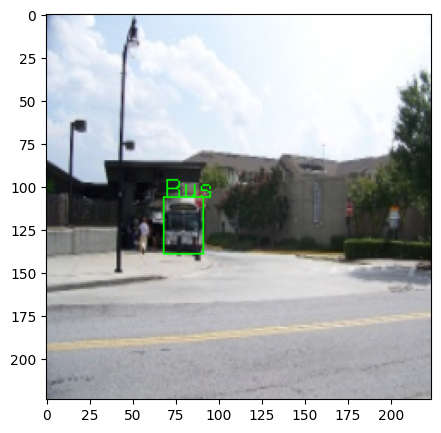

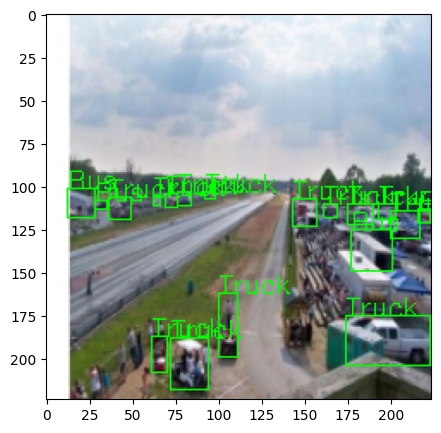

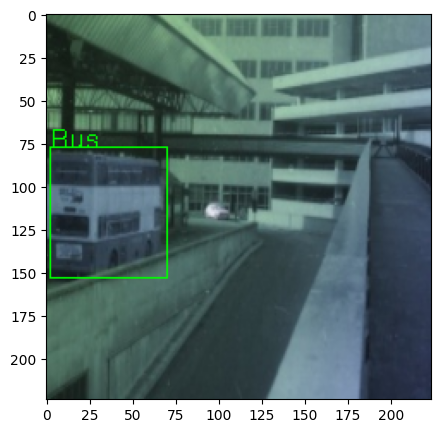

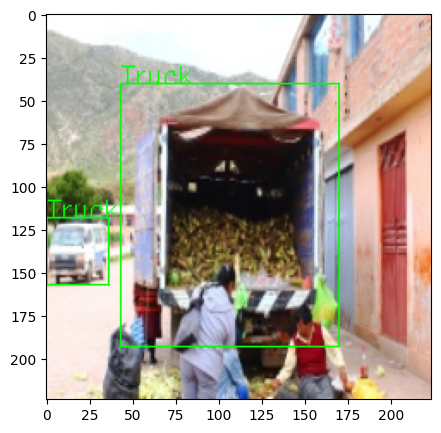

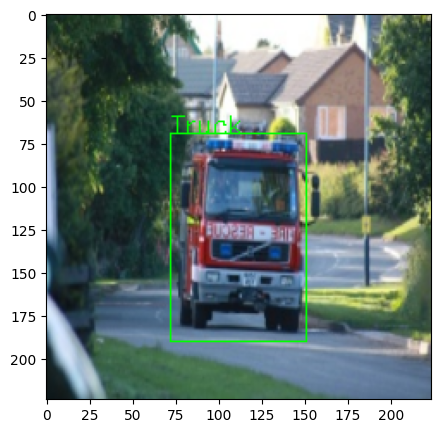

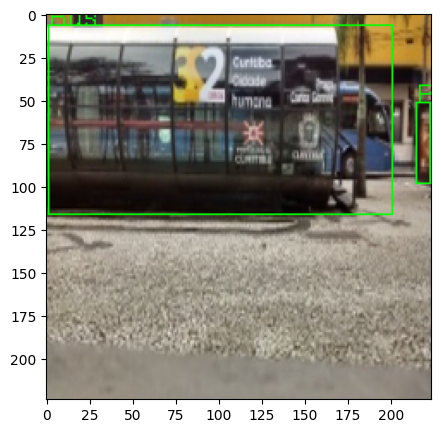

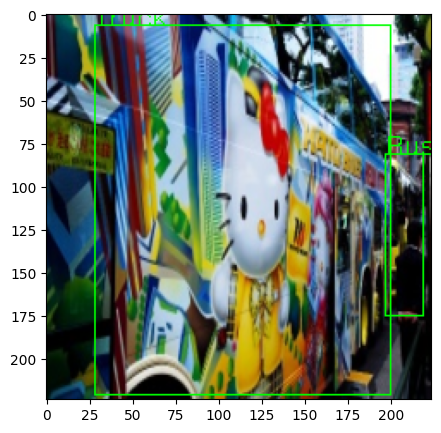

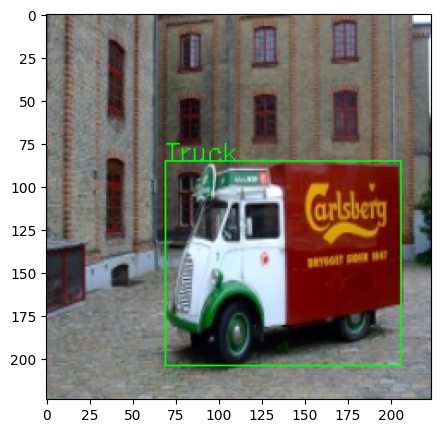

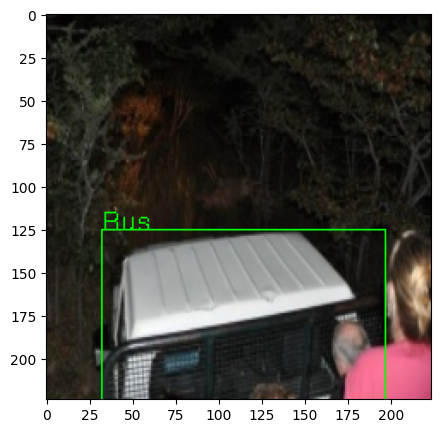

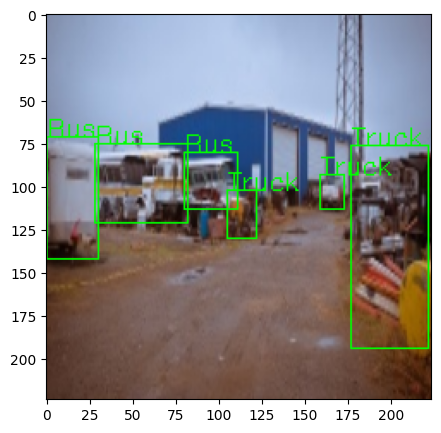

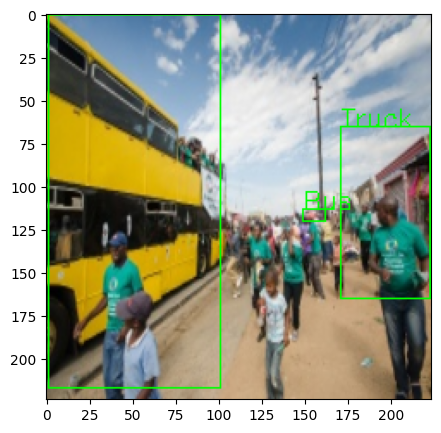

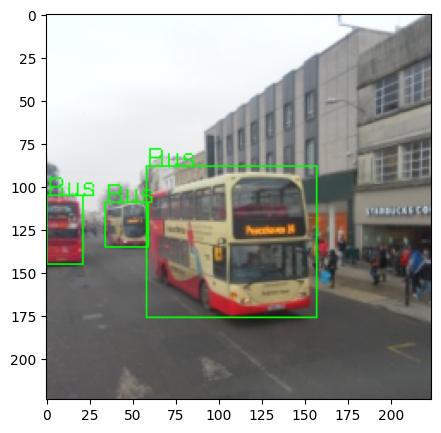

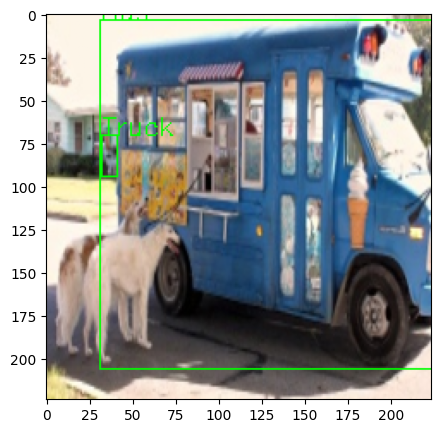

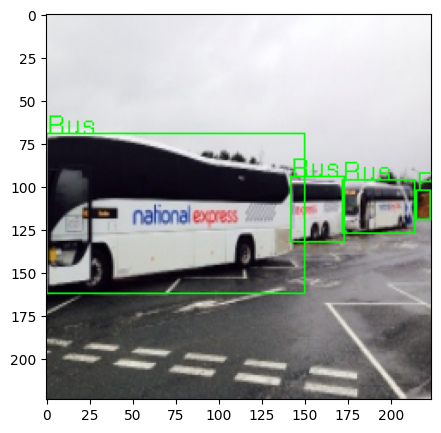

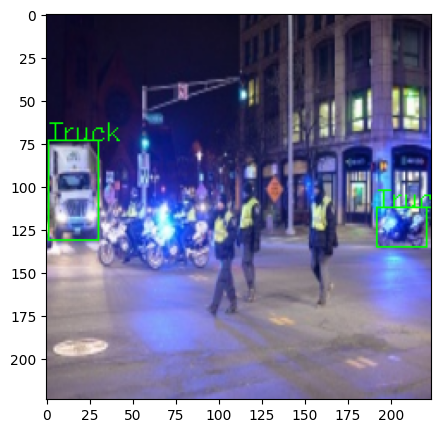

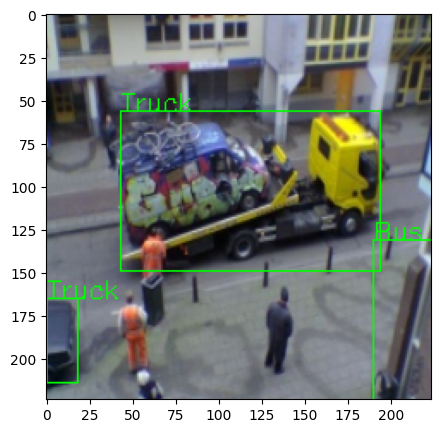

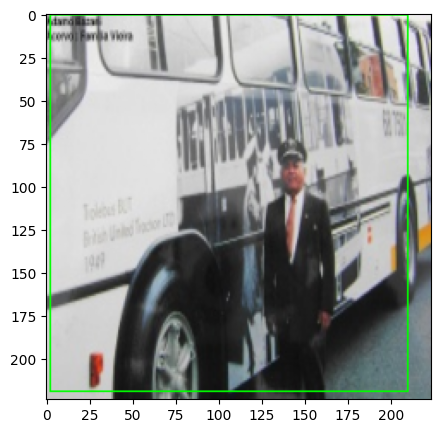

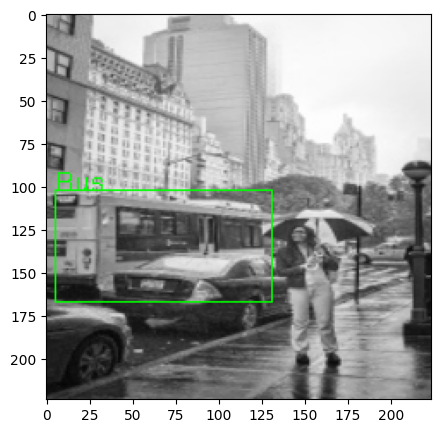

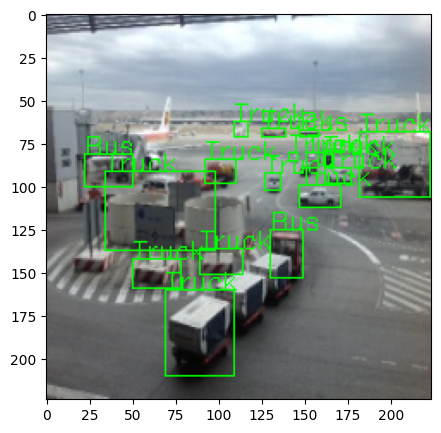

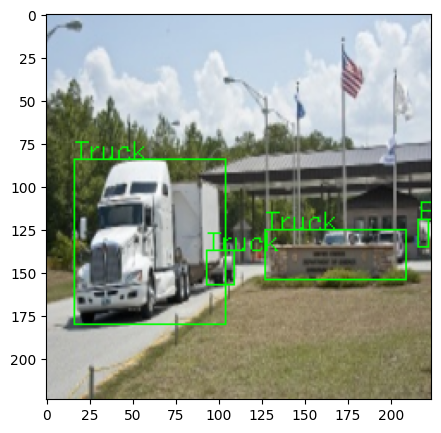

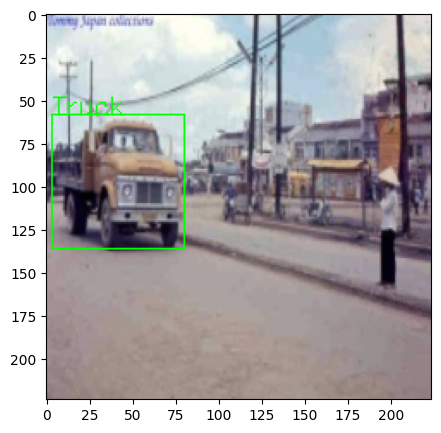

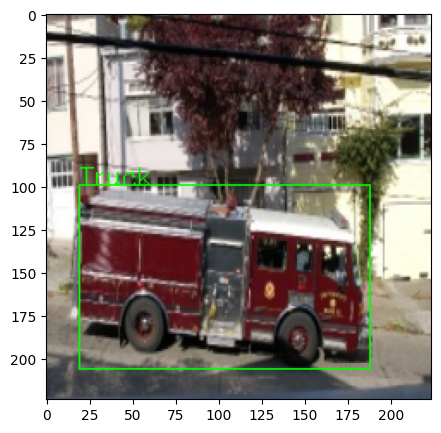

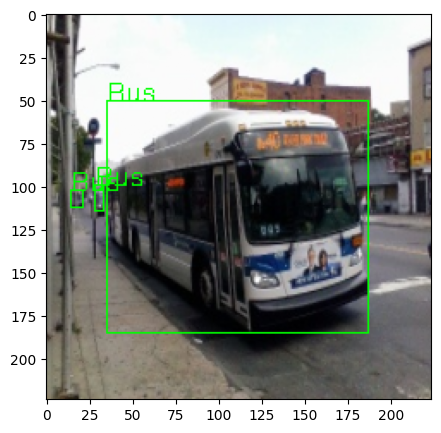

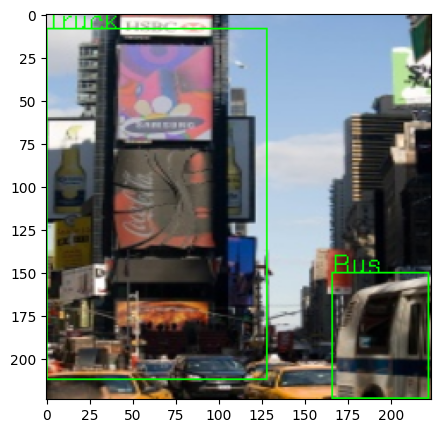

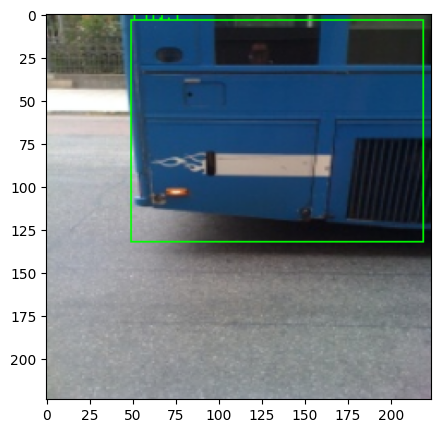

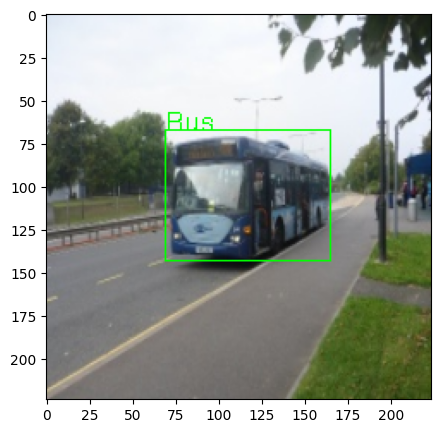

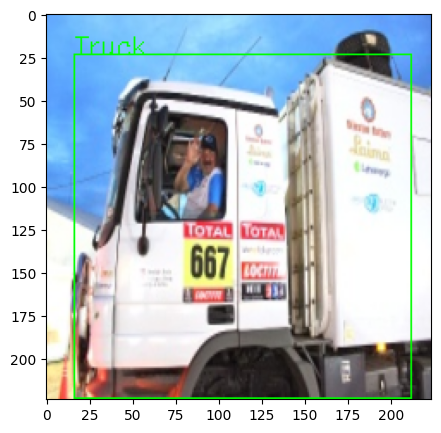

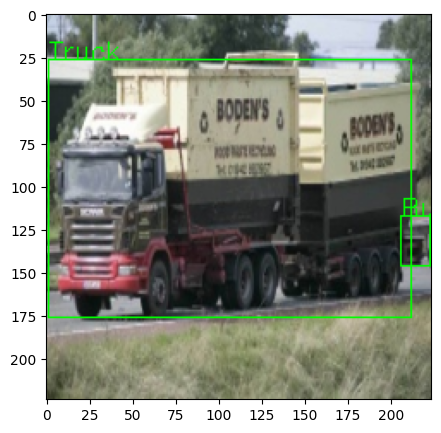

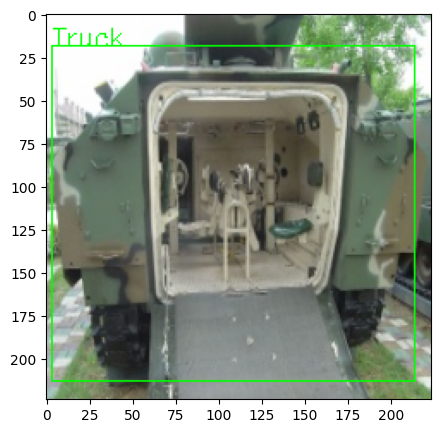

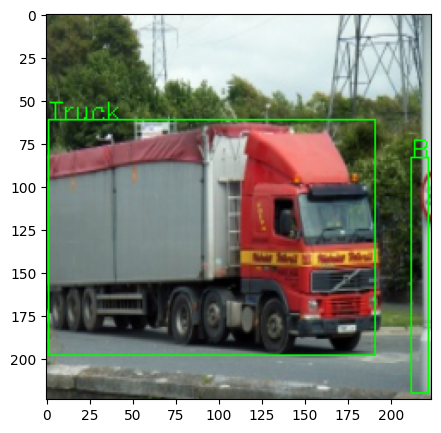

In [17]:
model.eval()
for ix, (images, targets) in enumerate(test_loader):
    if ix==3: break
    images = [im for im in images]
    outputs = model(images)
    for ix, output in enumerate(outputs):
        bbs, confs, labels = decode_output(output)
        info = [f'{l}@{c:.2f}' for l,c in zip(labels, confs)]
        show(images[ix].cpu().permute(1,2,0).detach().numpy(), bbs=bbs, texts=labels, sz=5)